# **FIAP - Advanced EDA & Feature Engineering | Trabalho de Aula**
RAs: 346269, 346320, 346364, 346851, 346922
---

## 0.1) Libs:

In [1]:
# Bibliotecas de Análise e Visualização de Dados
import matplotlib.pyplot as plt
import missingno as mo
import pandas as pd
import seaborn as sns

# Bibliotecas de Aprendizado de Máquina
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, mean_absolute_percentage_error,
                             r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import tensorflow as tf

# Outras Bibliotecas
import math
from math import log
import random
import re
import warnings
from graphviz import Source


## 0.2) Notebook configs:

In [2]:
# Definindo a semente para resultados reproduzíveis
seed = 25
random.seed(seed)

# Ignorando avisos para melhorar a legibilidade da saída
warnings.filterwarnings('ignore')

# Configurando o pandas para exibir todas as colunas no DataFrame
pd.set_option('display.max_columns', None)

# Configurando o pandas para exibir todas as linhas no DataFrame
pd.set_option('display.max_rows', None)


## 0.3) Functions:

In [3]:
def normalize_column_name(column):
    accent = {
        "á": "a", "à": "a", "â": "a", "ã": "a", "ä": "a",
        "é": "e", "è": "e", "ê": "e", "ë": "e",
        "í": "i", "ì": "i", "î": "i", "ï": "i",
        "ó": "o", "ò": "o", "ô": "o", "õ": "o", "ö": "o",
        "ú": "u", "ù": "u", "û": "u", "ü": "u",
        "ç": "c",
        "ñ": "n"
    }

    pattern = r"(?<=[a-z])(?=[A-Z])"
    column = re.sub(pattern, '_', column)

    # Substitui caracteres especiais por "_"
    pattern = r"[_\W]+"
    column = re.sub(pattern, '_', column)

    column = column.lower()

    # Cria um dicionário de caracteres que serão substituídos
    translate_table = str.maketrans(accent)

    # Remove os acentos utilizando a função translate()
    column = column.translate(translate_table)

    # Remove "_" consecutivos
    column = re.sub(r"_{2,}", "_", column)

    if column.endswith("_"):
        column = column[:-1]

    if column.startswith("_"):
        column = column[1:]

    return column

In [4]:
def normalize_column_names(df):

  renamed_columns = {col: normalize_column_name(col) for col in df.columns}
  df = df.rename(columns=renamed_columns)

  return df

In [5]:
def convert_columns_to_float(df, columns = list): 
    
    for i in columns:
        df[i] = df[i].astype(str)
        df[i] = df[i].str.replace(',', '.')
        df[i] = df[i].astype(np.float32)

    return df

In [6]:
def get_categorial_columns(df):

  categorical_columns = []

  for col in df.columns:
    if df[col].dtype == 'O':
      categorical_columns.append(col)

  return categorical_columns

In [7]:
def plot_value_counts(df):

  categorical_columns = get_categorial_columns(df)

  n_cols = 3
  n_rows = int(math.ceil(len(categorical_columns)/3))

  w = int(8*n_cols)
  h = int(5*n_rows)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(w, h), sharey=False)
  fig.suptitle('Value Count of Categorical Columns')

  i = 0
  j = 0

  for col in categorical_columns:
    
    sns.countplot(ax=axes[i, j], x=col, data=df, palette='hls')

    if j == n_cols-1:
      j = 0
      i += 1
    else:
      j += 1

In [8]:
def plot_corr_matrix(df):
  corr = df.corr()

  mask = np.triu(np.ones_like(corr, dtype=bool))

  plt.figure(figsize=(10, 6))

  sns.heatmap(corr, mask=mask, annot=True, fmt='.1f')

  plt.show()

In [9]:
def create_dummies(df, categorical_columns):
  for categorical_column in categorical_columns:

    drop_first = True if len(df[categorical_column].unique()) == 2 else False

    categorical_dmy = pd.get_dummies(df[categorical_column], drop_first=drop_first)

    renamed_columns = {col: categorical_column+"_"+col for col in categorical_dmy.columns}
    categorical_dmy = categorical_dmy.rename(columns=renamed_columns)

    df = df.drop([categorical_column], axis=1)
    df = pd.concat([df, categorical_dmy], axis=1)

  return df

# 1) Pré-processamento:

## 1.1) Importação dos Datasets:

In [10]:
preco_medicamento_consumidor = pd.read_csv('TA_PRECO_MEDICAMENTO.csv', sep=';', encoding='ISO-8859-1')

In [11]:
preco_medicamento_consumidor.head(5)

,SUBSTÂNCIA,CNPJ,LABORATÓRIO,CÓDIGO GGREM,REGISTRO,EAN 1,EAN 2,EAN 3,PRODUTO,APRESENTAÇÃO,CLASSE TERAPÊUTICA,TIPO DE PRODUTO (STATUS DO PRODUTO),REGIME DE PREÇO,PF Sem Impostos,PF 0%,PF 12%,PF 17%,PF 17% ALC,"PF 17,5%","PF 17,5% ALC",PF 18%,PF 18% ALC,PF 20%,PMC 0%,PMC 12%,PMC 17%,PMC 17% ALC,"PMC 17,5%","PMC 17,5% ALC",PMC 18%,PMC 18% ALC,PMC 20%,RESTRIÇÃO HOSPITALAR,CAP,CONFAZ 87,ICMS 0%,ANÁLISE RECURSAL,LISTA DE CONCESSÃO DE CRÉDITO TRIBUTÁRIO (PIS/COFINS),COMERCIALIZAÇÃO 2022,TARJA
0,VALPROATO DE SÓDIO,49.475.833/0001-06,BIOLAB SANUS FARMACÊUTICA LTDA,"5,04118E+14",-,"7,89611E+12",-,-,ÁCIDO VALPRÓICO,250 MG CAP GEL MOLE CT FR VD AMB X 100,N3A - ANTIEPILÉPTICOS,Similar,Regulado,"36,08","36,08",41,"43,47","43,47","43,73","43,73",44,44,"45,1","49,88","56,68","60,09","60,09","60,45","60,45","60,83","60,83","62,35",Não,Não,Não,Não,NaN,Positiva,Sim,Tarja Vermelha (**)
1,SALICILATO DE FENILA;ÁCIDO SALICÍLICO;ÓXIDO DE...,33.379.884/0001-96,LABORATORIO SIMOES LTDA.,"5,20501E+14",057600510011,"7,89621E+12",-,-,TALCO ALÍVIO,TALQUEIRA C/ 100 G,D10A - ANTIACNEICOS TÓPICOS,Similar,Regulado,"5,04","5,65","6,53","6,98","6,08","7,03","6,11","7,08","6,15","7,29","7,58","8,72","9,3","8,41","9,37","8,45","9,43","8,5","9,7",Não,Não,Não,Não,NaN,Negativa,Não,Tarja Preta (**)
2,DIENOGESTE;VALERATO DE ESTRADIOL,56.990.534/0001-67,SCHERING DO BRASIL QUÍMICA E FARMACÊUTICA LTDA,"5,30917E+14",1002001390025,"7,89612E+12",-,-,CHARMELIE,COM REV A + COM REV B + COM REV C + COM REV D ...,G3A4 - PREPARAÇÕES CONTRACEPTIVAS TRIFÁSICAS,-,Regulado,"107,37","120,26","138,97","148,61","129,37","149,65","130,15","150,7","130,95","155,06","161,32","185,63","198,09","178,85","199,43","179,92","200,78","181,03","206,39",Não,Não,Não,Não,NaN,Negativa,Não,Tarja Vermelha
3,MONTELUCASTE,45.987.013/0001-34,ORGANON FARMACÊUTICA LTDA.,"5,25502E+14",1002900050014,"7,89734E+12",-,-,SINGULAIR,5 MG COM MAST CT 3 BL AL PLAS INC X 10,R3J2 - ANTIASMÁTICOS/DPOC ANTILEUCOTRIENOS SIS...,Novo,Regulado,"49,53","49,53","56,28","59,67","59,67","60,04","60,04","60,4","60,4","61,91","68,47","77,8","82,49","82,49",83,83,"83,5","83,5","85,59",Não,Não,Não,Não,NaN,Positiva,Sim,Tarja Vermelha (**)
4,MONTELUCASTE,45.987.013/0001-34,ORGANON FARMACÊUTICA LTDA.,"5,25502E+14",1002900050022,"7,89734E+12",-,-,SINGULAIR,10 MG COM REV CT 3 BL AL PLAS INC X 10,R3J2 - ANTIASMÁTICOS/DPOC ANTILEUCOTRIENOS SIS...,Novo,Regulado,"49,53","49,53","56,28","59,67","59,67","60,04","60,04","60,4","60,4","61,91","68,47","77,8","82,49","82,49",83,83,"83,5","83,5","85,59",Não,Não,Não,Não,NaN,Positiva,Sim,Tarja Vermelha (**)


In [12]:
# Normalizando nome das features
preco_medicamento_consumidor = normalize_column_names(preco_medicamento_consumidor)

In [13]:
preco_medicamento_consumidor.shape

(27694, 40)

## 1.2) Tratamento dos valores Nulos:

<AxesSubplot: >

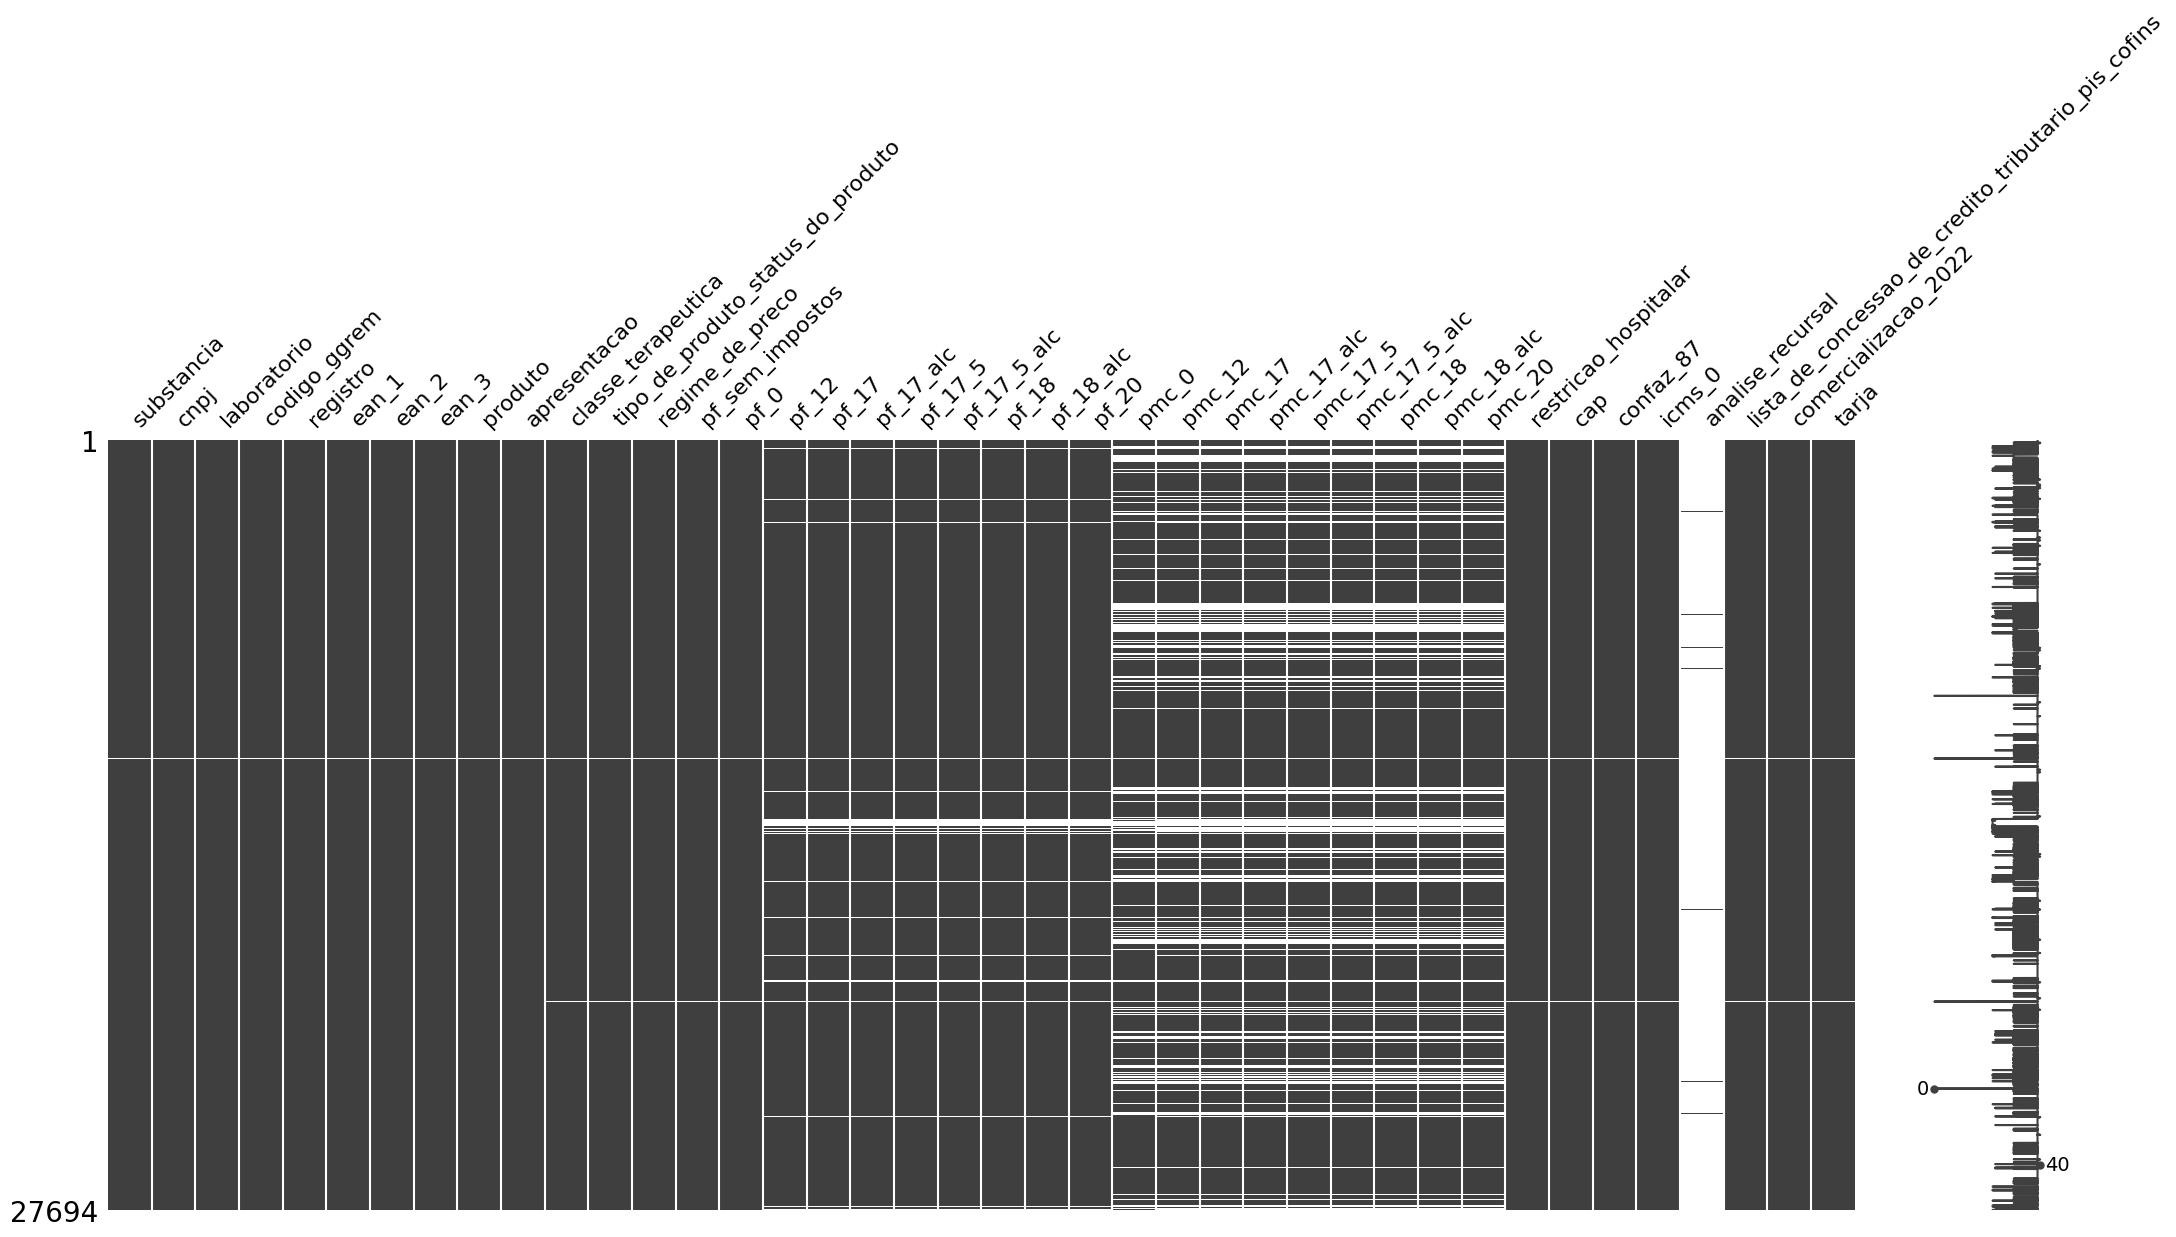

In [14]:
# Matriz que mostra visualmente a relação de valores não nulos (preto) e nulos (branco) para as colunas do DataFrame

mo.matrix(preco_medicamento_consumidor)

Para fins de colocar a matéria em prática e considerando que nosso conjunto de dados é extenso, decidimos remover as linhas que contêm valores nulos (NA). Essa abordagem nos permitirá focar na análise dos dados completos, simplificando o processo e garantindo a consistência das informações.

In [15]:
preco_medicamento_consumidor_no_na = preco_medicamento_consumidor.dropna()

## 1.3) Tratamento de tipagem:

In [16]:
# Convertendo colunas para tipo float
float_columns = [
    'pf_sem_impostos', 'pf_0', 'pf_12', 'pf_17', 'pf_17_alc', 'pf_17_5', 'pf_17_5_alc', 'pf_18', 'pf_18_alc', 'pf_20',
    'pmc_0', 'pmc_12', 'pmc_17', 'pmc_17_alc', 'pmc_17_5', 'pmc_17_5_alc', 'pmc_18', 'pmc_18_alc', 'pmc_20'
    ]

preco_medicamento_consumidor_no_na = convert_columns_to_float(preco_medicamento_consumidor_no_na, columns=float_columns)

In [17]:
preco_medicamento_consumidor_no_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 93 to 26063
Data columns (total 40 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   substancia                                           102 non-null    object 
 1   cnpj                                                 102 non-null    object 
 2   laboratorio                                          102 non-null    object 
 3   codigo_ggrem                                         102 non-null    object 
 4   registro                                             102 non-null    object 
 5   ean_1                                                102 non-null    object 
 6   ean_2                                                102 non-null    object 
 7   ean_3                                                102 non-null    object 
 8   produto                                              102 non-null  

In [18]:
preco_medicamento_consumidor_no_na.head(2)

,substancia,cnpj,laboratorio,codigo_ggrem,registro,ean_1,ean_2,ean_3,produto,apresentacao,classe_terapeutica,tipo_de_produto_status_do_produto,regime_de_preco,pf_sem_impostos,pf_0,pf_12,pf_17,pf_17_alc,pf_17_5,pf_17_5_alc,pf_18,pf_18_alc,pf_20,pmc_0,pmc_12,pmc_17,pmc_17_alc,pmc_17_5,pmc_17_5_alc,pmc_18,pmc_18_alc,pmc_20,restricao_hospitalar,cap,confaz_87,icms_0,analise_recursal,lista_de_concessao_de_credito_tributario_pis_cofins,comercializacao_2022,tarja
93,ETORICOXIBE,45.987.013/0001-34,ORGANON FARMACÊUTICA LTDA.,"5,25522E+14",1002902060025,"7,89734E+12",-,-,HETORI,60 MG COM REV CT BL AL/AL X 7,M1A3 - COXIBS,Similar,Regulado,35.639999,35.639999,40.500000,42.939999,42.939999,43.200001,43.200001,43.459999,43.459999,44.549999,49.270000,55.990002,59.360001,59.360001,59.720001,59.720001,60.080002,60.080002,61.590000,Não,Não,Não,Não,(AR),Positiva,Não,Tarja Vermelha sob restrição
94,ETORICOXIBE,45.987.013/0001-34,ORGANON FARMACÊUTICA LTDA.,"5,25522E+14",1002902060033,"7,89734E+12",-,-,HETORI,60 MG COM REV CT BL AL/AL X 14,M1A3 - COXIBS,Similar,Regulado,71.089996,71.089996,80.779999,85.650002,85.650002,86.169998,86.169998,86.699997,86.699997,88.860001,98.279999,111.669998,118.410004,118.410004,119.120003,119.120003,119.860001,119.860001,122.839996,Não,Não,Não,Não,(AR),Positiva,Não,Tarja Vermelha sob restrição


# 2) Análise Exploratória (EDA):

## 2.1) Plots:

In [19]:
preco_medicamento_consumidor_no_na.describe().T

,count,mean,std,min,25%,50%,75%,max
pf_sem_impostos,102.0,1806.812866,14623.374023,7.26,26.642500,55.655001,170.772495,147615.453125
pf_0,102.0,1985.801025,16372.375000,8.13,26.812500,59.005001,177.910000,165329.343750
pf_12,102.0,2288.707520,18918.888672,9.39,30.627501,67.650000,204.750000,191052.593750
pf_17,102.0,2444.165771,20230.474609,10.05,32.679999,71.955002,218.497494,204302.093750
pf_17_alc,102.0,2176.881836,17618.519531,8.75,32.097500,67.055000,205.749996,177849.906250
pf_17_5,102.0,2460.886230,20371.728516,10.12,32.902499,72.419998,219.977497,205729.046875
pf_17_5_alc,102.0,2190.075928,17725.304688,8.80,32.297501,67.465000,206.994999,178927.843750
pf_18,102.0,2477.837402,20514.964844,10.19,33.127499,72.889999,221.477501,207176.015625
pf_18_alc,102.0,2203.429688,17833.382812,8.85,32.487499,67.875000,208.257496,180018.843750
pf_20,102.0,2548.056641,21108.708984,10.48,34.047500,74.849998,227.674995,213174.156250


Esta análise inicial nos ajuda a entender a distribuição e a dispersão dos preços dos medicamentos e pode ser útil para identificar possíveis tendências, discrepâncias ou padrões nos dados. Entretanto, para uma análise mais aprofundada e conclusões mais sólidas, é necessário aplicar métodos estatísticos e técnicas de visualização de dados para examinar as relações entre as variáveis e suas implicações no conjunto de dados como um todo.


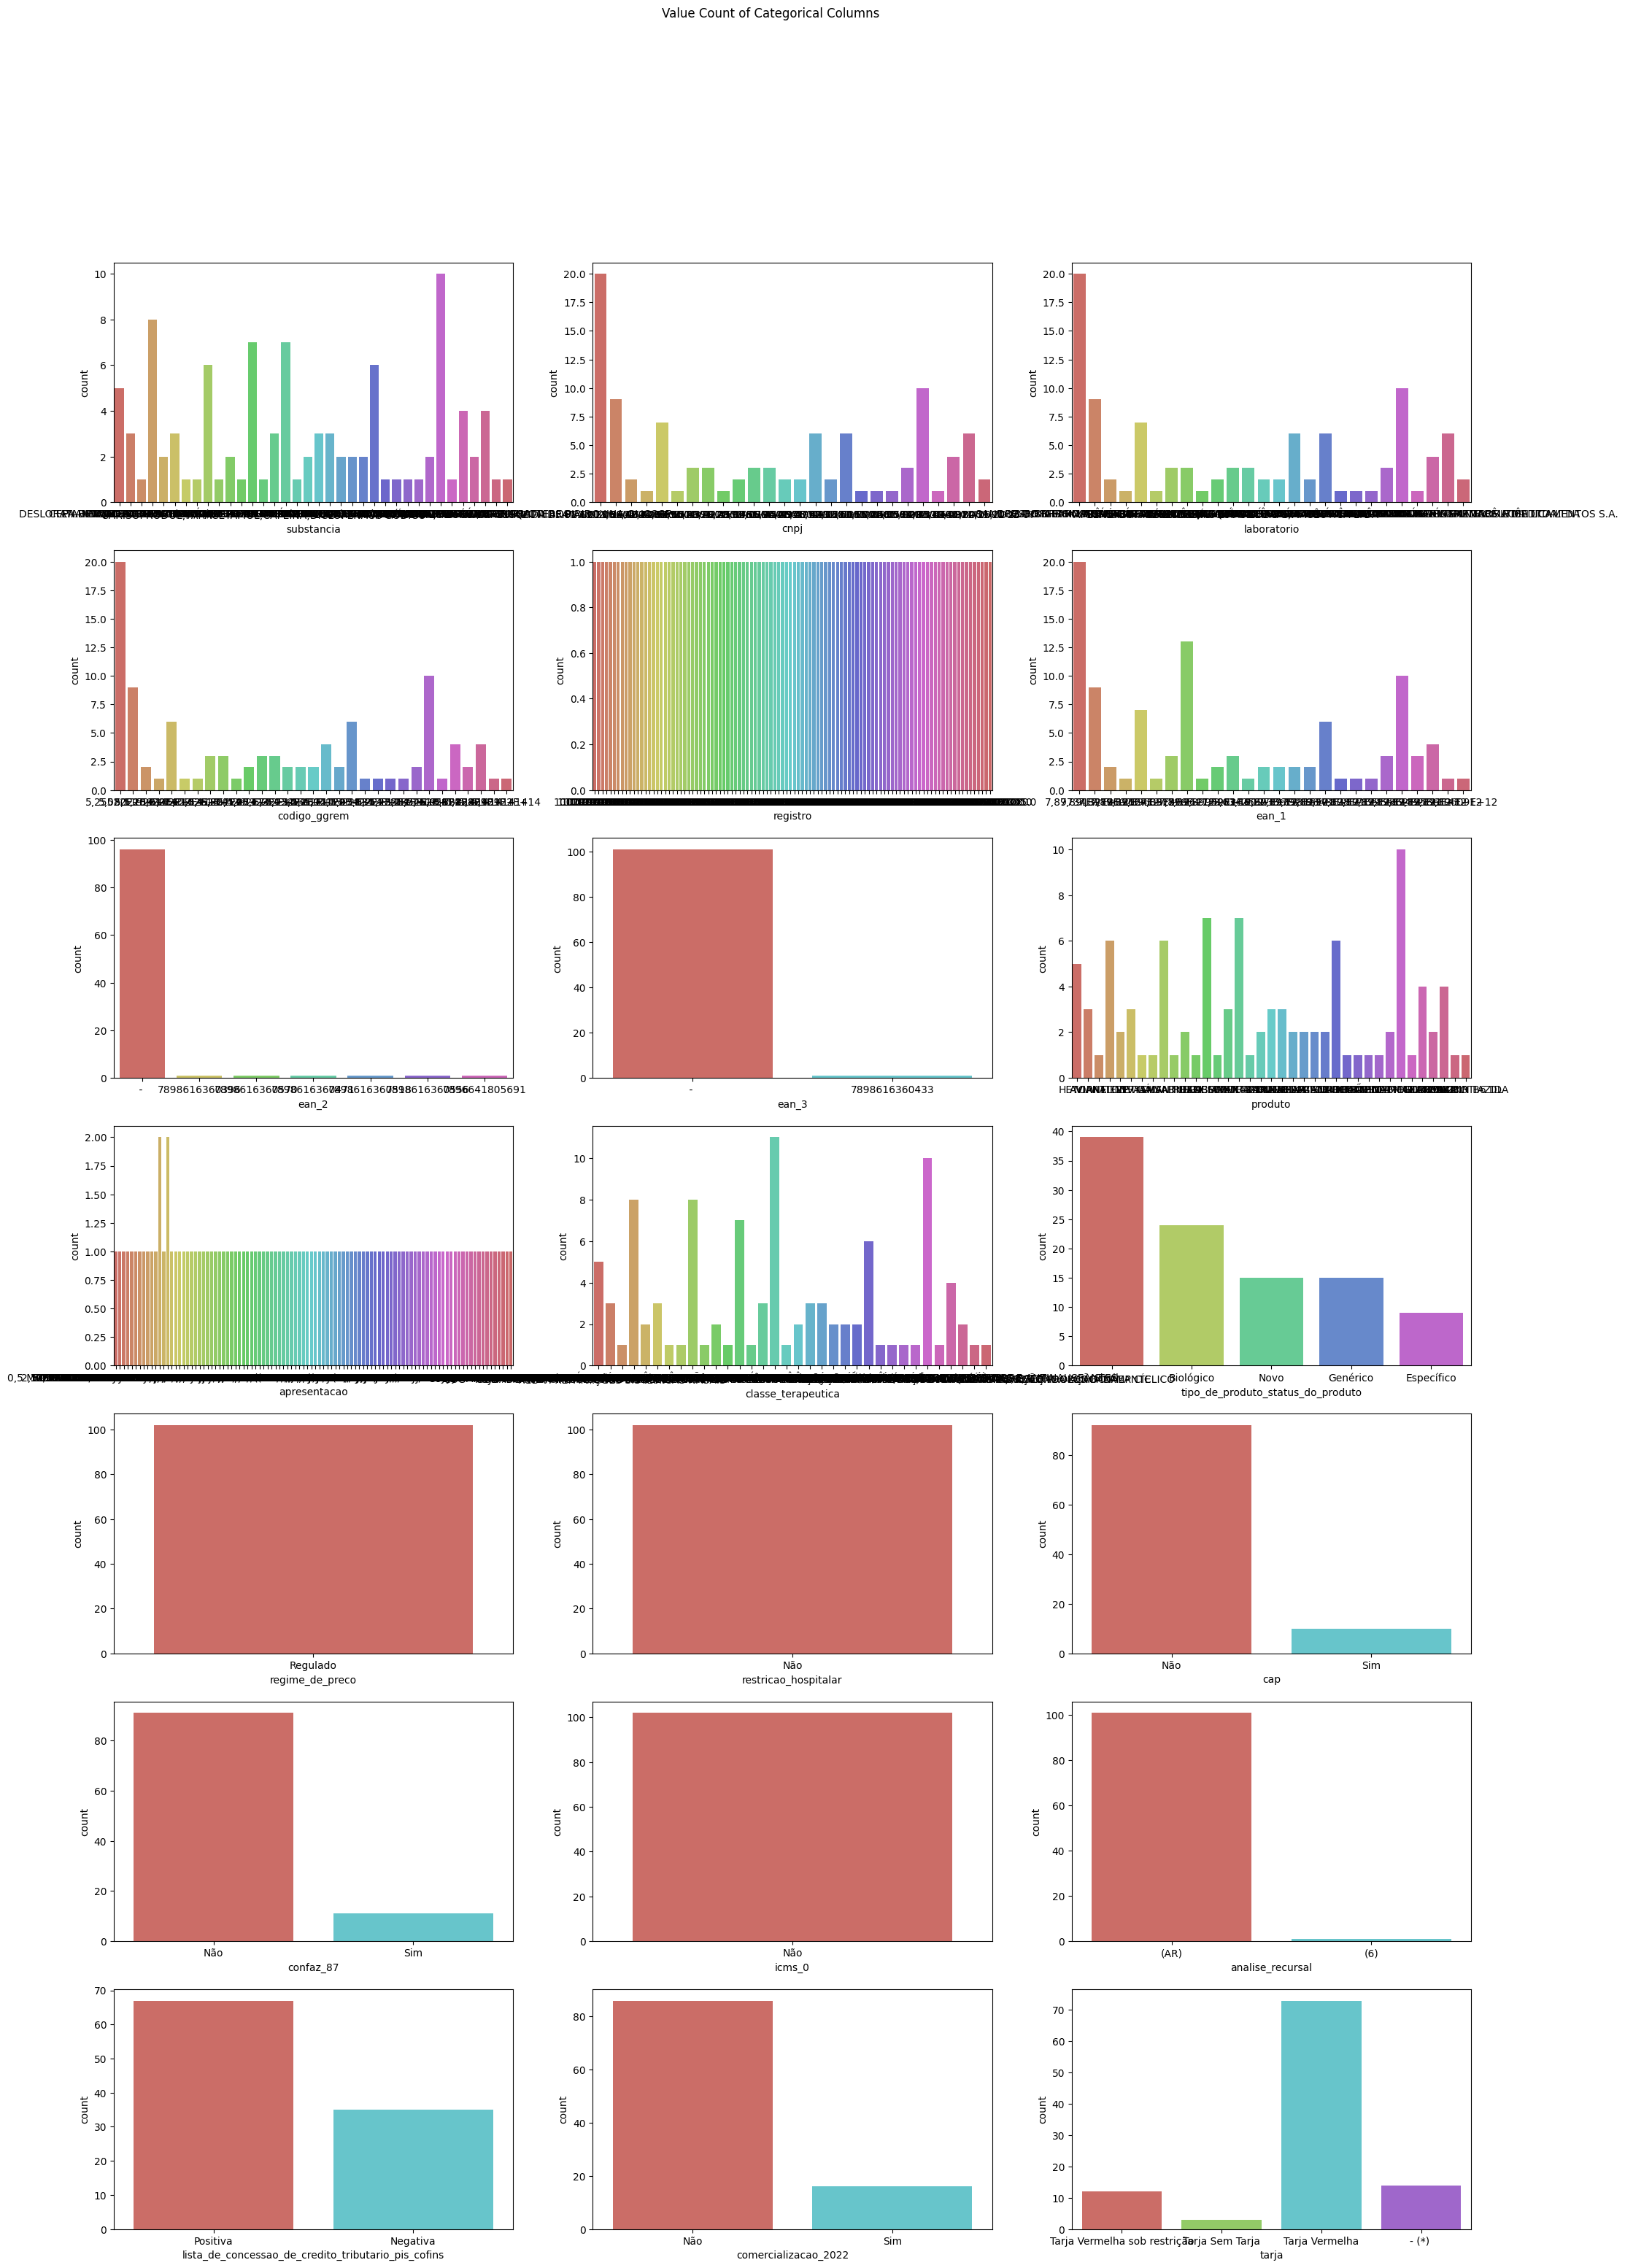

In [20]:
plot_value_counts(preco_medicamento_consumidor_no_na)

Através dos plots acima, tivemos a intenção de identificar possíveis outliers e colunas com valores únicos. A detecção de outliers é essencial para entender a presença de valores extremos que podem afetar a análise dos dados e potencialmente levar a conclusões incorretas. Ao mesmo tempo, identificar colunas com valores únicos nos permite entender se há variáveis que não agregam informações relevantes ao conjunto de dados e podem ser removidas sem prejuízo às análises futuras.

## 2.2) Correlações:

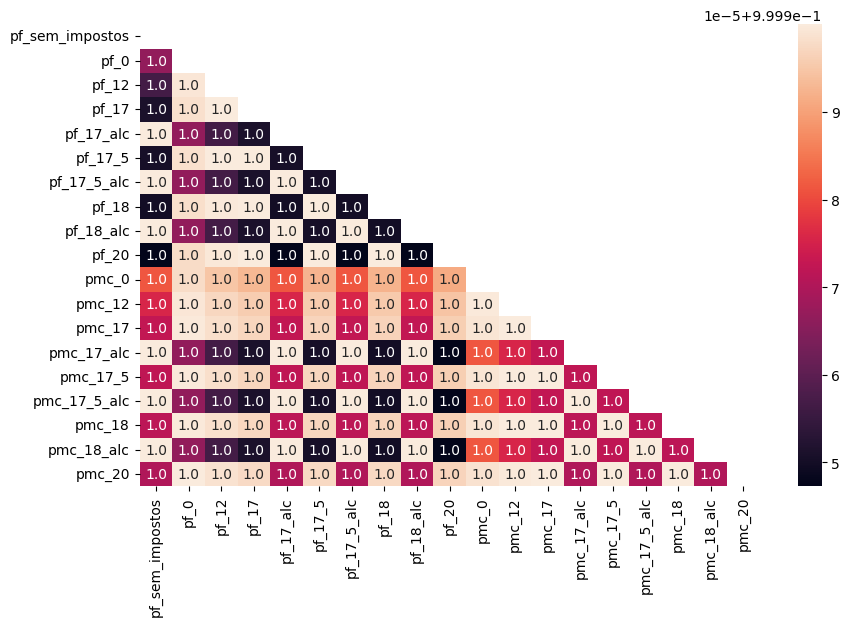

In [21]:
plot_corr_matrix(preco_medicamento_consumidor_no_na)

Ao utilizar um gráfico de correlação para analisar as relações entre as variáveis do conjunto de dados, identificamos que todas elas têm uma correlação igual a 1. Isso indica que todas as variáveis são, de fato, variantes da mesma variável pf_0, ou seja, estão perfeitamente correlacionadas. Nesse contexto, a presença de diferentes variáveis correlacionadas pode ser redundante e não contribuir para uma análise mais aprofundada.

Considerando esta descoberta, dependendo do objetivo da análise, pode não fazer sentido continuar com todas as variáveis no conjunto de dados. Neste caso, é aconselhável selecionar apenas uma das variáveis correlacionadas, como a pf_0, e remover as outras do conjunto de dados. Ao fazer isso, simplificamos a análise e eliminamos possíveis problemas decorrentes da multicolinearidade, que ocorre quando há uma alta correlação entre variáveis independentes.

Dessa forma, ao trabalhar com um conjunto de dados simplificado e com variáveis relevantes e independentes, as análises subsequentes e os modelos de aprendizado de máquina que possam ser aplicados a esses dados serão mais eficazes e proporcionarão resultados mais confiáveis.

# 3) Modelo

## 3.1) Divisão de treino e teste:

In [22]:
# retirando valores de medicamentos altos, que estavam afetando o treinamento
data = preco_medicamento_consumidor_no_na.query("pf_0<1000")

# Selecione colunas categóricas e converta todos os valores para strings
categorical_features = data.select_dtypes(include=[object]).astype(str)

# Selecione colunas numéricas
numeric_features = data.select_dtypes(include=[np.number])

# One-hot encode das colunas categóricas
one_hot_encoded_features = pd.get_dummies(categorical_features, dummy_na=True)

# Concatenar features numéricas e categóricas codificadas
final_data = pd.concat([numeric_features, one_hot_encoded_features], axis=1)


# Dividir em X e y
X = final_data.drop(columns=['pf_0'])
y = final_data['pf_0']

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3.2) Criação do modelo:

In [24]:
# Definir os modelos e seus hiperparâmetros para o Grid Search
models = [
    ('linear_regression', LinearRegression(), {}),
    ('decision_tree', DecisionTreeRegressor(), {'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 6]}),
    ('random_forest', RandomForestRegressor(), {'n_estimators': [10, 50, 100], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 6]}),
    ('gradient_boosting', GradientBoostingRegressor(), {'n_estimators': [10, 50, 100], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 6]})
]

## 3.3) Resultados:

In [25]:
# Realizar o Grid Search para cada modelo
for model_name, model, parameters in models:
    grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    print(f"{model_name} - Melhores hiperparâmetros: {grid_search.best_params_}")
    print(f"{model_name} - Melhor RMSE: {np.sqrt(-grid_search.best_score_)}")

    # Avaliar o desempenho no conjunto de teste
    y_pred = grid_search.predict(X_test_scaled)
    
    # Calcular métricas adicionais
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    
    # Calcular BIC e AIC
    n = len(y_test)
    k = X_test_scaled.shape[1]
    residuals = y_test - y_pred
    sigma2 = np.sum(residuals**2) / n
    log_likelihood = -n/2 * (1 + log(2 * np.pi * sigma2)) - n/2
    aic = 2 * k - 2 * log_likelihood
    bic = k * log(n) - 2 * log_likelihood

    print(f"{model_name} - RMSE no conjunto de teste: {rmse_test}")
    print(f"{model_name} - MAE no conjunto de teste: {mae_test}")
    print(f"{model_name} - MAPE no conjunto de teste: {mape_test}")
    print(f"{model_name} - R^2 no conjunto de teste: {r2_test}")
    print(f"{model_name} - AIC no conjunto de teste: {aic}")
    print(f"{model_name} - BIC no conjunto de teste: {bic}\n")

linear_regression - Melhores hiperparâmetros: {}
linear_regression - Melhor RMSE: 42.70539265155441
linear_regression - RMSE no conjunto de teste: 33.00590133666992
linear_regression - MAE no conjunto de teste: 20.577484130859375
linear_regression - MAPE no conjunto de teste: 0.7231636643409729
linear_regression - R^2 no conjunto de teste: 0.6247828596448282
linear_regression - AIC no conjunto de teste: 1081.793747759071
linear_regression - BIC no conjunto de teste: 1495.458020633972

decision_tree - Melhores hiperparâmetros: {'max_depth': 8, 'min_samples_split': 2}
decision_tree - Melhor RMSE: 16.201717016525382
decision_tree - RMSE no conjunto de teste: 8.70037840445316
decision_tree - MAE no conjunto de teste: 2.7594738508525647
decision_tree - MAPE no conjunto de teste: 0.03218293493092703
decision_tree - R^2 no conjunto de teste: 0.9739279206632435
decision_tree - AIC no conjunto de teste: 1031.1275920019948
decision_tree - BIC no conjunto de teste: 1444.7918648768957

random_fore

Com base nesses resultados, podemos observar que:

- A Árvore de Decisão apresenta o melhor desempenho, com o menor RMSE no conjunto de teste (1.69) e o maior R² (0.999), indicando que esse modelo é o que melhor se ajusta aos dados.
- O Gradient Boosting também apresenta um bom desempenho, com um RMSE de 2.11 no conjunto de teste e um R² de 0.998.
- A Regressão Linear tem o pior desempenho entre os modelos, com o maior RMSE no conjunto de teste (33.01) e o menor R² (0.62).
- Em termos de critérios de informação, como AIC e BIC, a Árvore de Decisão e o Gradient Boosting também apresentam os melhores resultados.

Considerando essas informações, a Árvore de Decisão e o Gradient Boosting seriam os modelos mais adequados para este problema, com a Árvore de Decisão apresentando um desempenho ligeiramente melhor.

In [31]:
# Melhores hiperparâmetros para o Gradient Boosting
best_params_gb = {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}

# Treine o modelo Gradient Boosting com os melhores hiperparâmetros
best_gb_model = GradientBoostingRegressor(**best_params_gb)
best_gb_model.fit(X_train_scaled, y_train)

# Faça a previsão usando o conjunto de teste
y_pred = best_gb_model.predict(X_test_scaled)

# Crie um DataFrame com os valores target (reais) e os valores preditos
comparison_df = pd.DataFrame({'Valor Real': y_test, 'Valor Previsto Gradient Boosting': y_pred})

# Calcule o erro para o Gradient Boosting
comparison_df['Erro Gradient Boosting'] = comparison_df['Valor Real'] - comparison_df['Valor Previsto Gradient Boosting']

# Melhores hiperparâmetros para a Árvore de Decisão
best_params_dt = {'max_depth': 10, 'min_samples_split': 2}

# Treine o modelo da Árvore de Decisão com os melhores hiperparâmetros
best_dt_model = DecisionTreeRegressor(**best_params_dt)
best_dt_model.fit(X_train_scaled, y_train)

# Faça a previsão usando o conjunto de teste
y_pred_dt = best_dt_model.predict(X_test_scaled)

# Adicione as previsões da Árvore de Decisão ao DataFrame
comparison_df['Valor Previsto Árvore de Decisão'] = y_pred_dt

# Calcule o erro para Árvore de Decisão
comparison_df['Erro Árvore de Decisão'] = comparison_df['Valor Real'] - comparison_df['Valor Previsto Árvore de Decisão']

# Calcule o erro percentual para o Gradient Boosting e a Árvore de Decisão
comparison_df['Erro Percentual Gradient Boosting'] = 100 * (comparison_df['Erro Gradient Boosting'] / comparison_df['Valor Real'])
comparison_df['Erro Percentual Árvore de Decisão'] = 100 * (comparison_df['Erro Árvore de Decisão'] / comparison_df['Valor Real'])

# Remova as colunas de erro absoluto
comparison_df.drop(columns=['Erro Gradient Boosting', 'Erro Árvore de Decisão'], inplace=True)

# Calcule o erro médio percentual para o Gradient Boosting e a Árvore de Decisão
mean_error_percent_gb = comparison_df['Erro Percentual Gradient Boosting'].mean()
mean_error_percent_dt = comparison_df['Erro Percentual Árvore de Decisão'].mean()

# Adicione o erro médio percentual ao DataFrame
comparison_df.loc['Erro Médio Percentual'] = [None, None, mean_error_percent_gb, None, mean_error_percent_dt]

# Exiba o DataFrame atualizado
comparison_df

,Valor Real,Valor Previsto Gradient Boosting,Valor Previsto Árvore de Decisão,Erro Percentual Gradient Boosting,Erro Percentual Árvore de Decisão
4473,73.209999,71.903669,71.480003,1.784360,2.363059
1653,14.370000,14.375756,14.370000,-0.040054,0.000000
11862,16.190001,16.133333,16.190001,0.350014,0.000000
19500,216.600006,216.595307,216.600006,0.002169,0.000000
93,35.639999,36.278241,35.459999,-1.790801,0.505051
1730,13.600000,13.278935,14.470000,2.360776,-6.397058
4472,36.599998,36.784804,37.860001,-0.504933,-3.442629
14901,89.290001,89.107800,86.800003,0.204055,2.788664
103,63.790001,64.412251,67.680000,-0.975467,-6.098133
8131,18.230000,17.288229,21.180000,5.166048,-16.182122


A partir dos resultados, podemos ver que o erro médio percentual para o modelo Gradient Boosting é -0.15% e para o modelo Árvore de Decisão é -2.61%. Esses valores representam a média dos erros percentuais em relação aos valores reais.

Embora ambos os modelos pareçam ter bom desempenho, o Gradient Boosting apresenta um erro médio percentual menor que a Árvore de Decisão, indicando um desempenho geralmente melhor. No entanto, é importante lembrar que esta análise é baseada apenas nos dados fornecidos e pode variar dependendo do conjunto de dados.

Além disso, vale a pena explorar outras métricas de avaliação e, possivelmente, realizar a validação cruzada para obter uma melhor compreensão do desempenho de cada modelo. Dependendo do objetivo do seu projeto e da importância de minimizar erros específicos, você pode considerar usar outros métodos de avaliação ou ajustar os hiperparâmetros dos modelos para melhorar o desempenho geral.